# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ). 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [ ]:
# pip install xgboost
# import sys
# !{sys.executable} -m pip install seaborn matplotlib scikit-learn boto3 sagemaker scipy xgboost
# !{sys.executable} -m pip install --upgrade sagemaker

# # load libraries
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import io

import seaborn as sns

sns.set()   

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sagemaker.serializers import CSVSerializer
from sagemaker import image_uris
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [2]:
# load data
combined1 = pd.read_csv('combined_csv_v1.csv')
combined2 = pd.read_csv('combined_csv_v2.csv')

In [3]:
# print shape
print(combined1.shape, combined2.shape)

(1635590, 75) (1635590, 88)


In [4]:
# print head
print(combined1.head(), combined2.head())

   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_Morning  DepHourofDay_Afternoon  \
0     False

### 1. Split data into training, validation and testing sets (70% - 15% - 15%).

In [5]:
# Uploading the data to Amazon S3
bucket='c135321a3429026l8143085t1w99238260611-flightbucket-zhefvkalbrel'
prefix='oncloudproject'

In [ ]:
#Split data for combined1
train1, test_and_validate1 = train_test_split(combined1, test_size=0.3, random_state=42, stratify=combined1['target'])
# split the *test_and_validate* dataset into two equal parts (15% each)
test1, validate1 = train_test_split(test_and_validate1, test_size=0.5, random_state=42, stratify=test_and_validate1['target'])

#Split data for combined2
train2, test_and_validate2 = train_test_split(combined2, test_size=0.3, random_state=42, stratify=combined2['target'])
# split the *test_and_validate* dataset into two equal parts (15% each)
test2, validate2 = train_test_split(test_and_validate2, test_size=0.5, random_state=42, stratify=test_and_validate2['target'])

# check the shape of the splited datasets of combined1
print(train1.shape)
print(test1.shape)
print(validate1.shape)

# check the shape of the splited datasets of combined2
print(train2.shape)
print(test2.shape)
print(validate2.shape)

# # Uploading the data to Amazon S3
# bucket='c135321a3429026l8143085t1w99238260611-flightbucket-zhefvkalbrel'
# prefix='oncloudproject'

# Define the filenames
train1_file='combine1_train.csv'
test1_file='combine1_test.csv'
validate1_file='combine1_validate.csv'

# Define the filenames
train2_file='combine2_train.csv'
test2_file='combine2_test.csv'
validate2_file='combine2_validate.csv'

# Define the function to upload the files to S3
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    # The io.StringIO() creates an in-memory text stream, which allows you to write CSV data to a file-like object instead of a physical disk.
    csv_buffer = io.StringIO()
    # Convert the DataFrame to CSV format and directly write it into the already created csv_buffer
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())
    
# Call the function to upload the files to S3 for combined1
upload_s3_csv(train1_file, 'train', train1)
upload_s3_csv(test1_file, 'test', test1)
upload_s3_csv(validate1_file, 'validate', validate1)

# Call the function to upload the files to S3 for combined2
upload_s3_csv(train2_file, 'train', train2)
upload_s3_csv(test2_file, 'test', test2)
upload_s3_csv(validate2_file, 'validate', validate2)

(1144913, 75)
(245338, 75)
(245339, 75)
(1144913, 88)
(245338, 88)
(245339, 88)


### 2. Use linear learner estimator to build a classifcation model.

In [7]:
# Retrieve the AWS region to find the right container image
region = boto3.Session().region_name

# Retrieve the image URI for Linear Learner
container = image_uris.retrieve('linear-learner', region)

# Define hyperparameters
hyperparams = {
    'predictor_type': 'binary_classifier',  # Since it's a classification problem
    'binary_classifier_model_selection_criteria': 'f1',  # Criterion for model selection using f1 score
    'use_bias': True  # Use bias in the model
}

# Set up S3 output location
s3_output1_location = f"s3://{bucket}/{prefix}/output/result1/"
s3_output2_location = f"s3://{bucket}/{prefix}/output/result2/"

# Set up the linear learner estimator for combined1
linear_learner1 = sagemaker.estimator.Estimator(role=sagemaker.get_execution_role(),
                               instance_count=1,
                               instance_type='ml.m4.xlarge',
                               sagemaker_session=sagemaker.Session(),
                               output_path=s3_output1_location,
                               image_uri=container,
                               hyperparameters=hyperparams,
                               )

# Set up the linear learner estimator for combined2
linear_learner2 = sagemaker.estimator.Estimator(role=sagemaker.get_execution_role(),
                               instance_count=1,
                               instance_type='ml.m4.xlarge',
                               sagemaker_session=sagemaker.Session(),
                               output_path=s3_output2_location,
                               image_uri=container,
                               hyperparameters=hyperparams,
                               )

# Set up the data channels for combined1
train1_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train/combine1_train.csv",
    content_type='text/csv')  # Data format is CSV

validate1_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validate/combine1_validate.csv",
    content_type='text/csv')  # Data format is CSV

data1_channels = {'train': train1_channel, 'validation': validate1_channel}

# Set up the data channels for combined2
train2_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train/combine2_train.csv",
    content_type='text/csv')  # Data format is CSV

validate2_channel = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validate/combine2_validate.csv",
    content_type='text/csv')  # Data format is CSV

data2_channels = {'train': train2_channel, 'validation': validate2_channel}

# Fit the model for combined1
linear_learner1.fit(inputs=data1_channels)

# Fit the model for combined2
linear_learner2.fit(inputs=data2_channels)

INFO:sagemaker:Creating training-job with name: linear-learner-2024-10-31-02-56-33-876


2024-10-31 02:56:35 Starting - Starting the training job...
2024-10-31 02:56:50 Starting - Preparing the instances for training...
2024-10-31 02:57:14 Downloading - Downloading input data...
2024-10-31 02:57:49 Downloading - Downloading the training image......
2024-10-31 02:59:01 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/31/2024 02:59:22 INFO 140658032576320] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 

INFO:sagemaker:Creating training-job with name: linear-learner-2024-10-31-03-05-26-663


Training seconds: 477
Billable seconds: 477
2024-10-31 03:05:26 Starting - Starting the training job...
2024-10-31 03:05:49 Starting - Preparing the instances for training...
2024-10-31 03:06:11 Downloading - Downloading input data...
2024-10-31 03:06:56 Downloading - Downloading the training image......
2024-10-31 03:07:57 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/31/2024 03:08:19 INFO 140202859149120] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'ini

### 3. Host the model on another instance

In [8]:
# Deploy the trained model for combined1
linear_predictor1 = linear_learner1.deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge',
                                         serializer=sagemaker.serializers.CSVSerializer())

# Deploy the trained model for combined2
linear_predictor2 = linear_learner2.deploy(initial_instance_count=1,
                                         instance_type='ml.m4.xlarge',
                                         serializer=sagemaker.serializers.CSVSerializer())

# use the delete_endpoint function to delete the endpoint
linear_predictor1.delete_endpoint(delete_endpoint_config=True)

# use the delete_endpoint function to delete the endpoint
linear_predictor2.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Creating model with name: linear-learner-2024-10-31-03-40-49-259
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-10-31-03-40-49-259
INFO:sagemaker:Creating endpoint with name linear-learner-2024-10-31-03-40-49-259


--------!

INFO:sagemaker:Creating model with name: linear-learner-2024-10-31-03-45-21-485
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-10-31-03-45-21-485
INFO:sagemaker:Creating endpoint with name linear-learner-2024-10-31-03-45-21-485


--------!

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-10-31-03-40-49-259
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-10-31-03-40-49-259
INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2024-10-31-03-45-21-485
INFO:sagemaker:Deleting endpoint with name: linear-learner-2024-10-31-03-45-21-485


### 4. Perform batch transform to evaluate the model on testing data

In [10]:
# Select the columns excluding the target column for the batch transform input
batch_ll_X1 = test1.iloc[:,1:]  # Adjust index if target is not the first column
batch_ll_X2 = test2.iloc[:,1:]  

# Replace 'TRUE'/'FALSE' strings with 1 and 0
batch_ll_X1 = batch_ll_X1.replace({'TRUE': 1, 'FALSE': 0})
batch_ll_X2 = batch_ll_X2.replace({'TRUE': 1, 'FALSE': 0})

# Convert all boolean columns to integers (True to 1, False to 0)
batch_ll_X1 = batch_ll_X1.applymap(lambda x: int(x) if isinstance(x, bool) else x)
batch_ll_X2 = batch_ll_X2.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Files for batch transform input
batch_ll_X1_file = 'batch-in1.csv'
batch_ll_X2_file = 'batch-in2.csv'

# Upload the test data for batch transform to S3
upload_s3_csv(batch_ll_X1_file, 'batch_ll_in', batch_ll_X1)
upload_s3_csv(batch_ll_X2_file, 'batch_ll_in', batch_ll_X2)

# Define the output paths for the batch transform results
batch_ll_output1 = f"s3://{bucket}/{prefix}/batch_ll_output1/"
batch_ll_output2 = f"s3://{bucket}/{prefix}/batch_ll_output2/"

# Define input paths for the batch transform data
batch_ll_input1 = f"s3://{bucket}/{prefix}/batch_ll_in/{batch_ll_X1_file}"
batch_ll_input2 = f"s3://{bucket}/{prefix}/batch_ll_in/{batch_ll_X2_file}"

# Create transformer objects for both models
ll_transformer1 = linear_learner1.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=batch_ll_output1,
    strategy='MultiRecord',
    assemble_with='Line'
)

ll_transformer2 = linear_learner2.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=batch_ll_output2,
    strategy='MultiRecord',
    assemble_with='Line'
)

# Perform batch transformations
ll_transformer1.transform(
    data=batch_ll_input1,
    content_type='text/csv',
    split_type='Line'
)

ll_transformer2.transform(
    data=batch_ll_input2,
    content_type='text/csv',
    split_type='Line'
)

# Wait for transformation jobs to complete
ll_transformer1.wait()
ll_transformer2.wait()

INFO:sagemaker:Creating model with name: linear-learner-2024-10-31-04-15-34-879
INFO:sagemaker:Creating model with name: linear-learner-2024-10-31-04-15-35-532
INFO:sagemaker:Creating transform job with name: linear-learner-2024-10-31-04-15-37-247


.............................................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[10/31/2024 04:23:05 INFO 140568942139200] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[10/31/2024 04:23:05 INFO 140568942139200] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
/opt/amazon/lib/python3.8/site-packages/mxnet/

INFO:sagemaker:Creating transform job with name: linear-learner-2024-10-31-04-23-31-398


...........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[10/31/2024 04:30:46 INFO 140657513711424] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[10/31/2024 04:30:50 WARNING 140657513711424] Loggers have already been setup.
[10/31/2024 04:30:50 INFO 140657513711424] loaded entry point class algorithm.serve.server_config:config_api
[10/31/2024 04:30:50 INFO 140657513711424] loading entry points
[10/31/2024 04

### 5. Report the performance metrics that you see better test the model performance 


Accuracy: 0.7902
F1 Score: 0.0066
Precision: 0.5603
Recall: 0.0033 



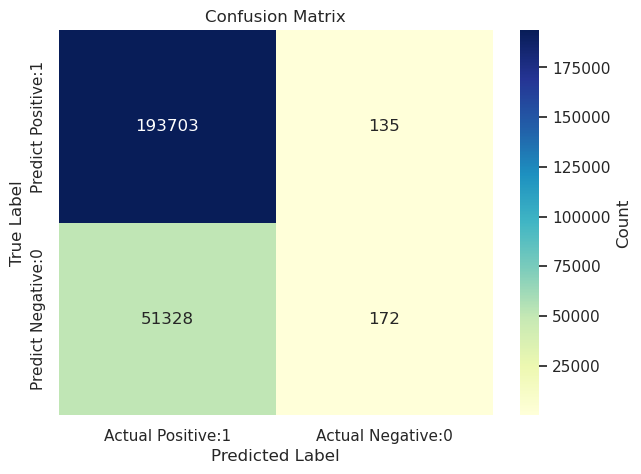

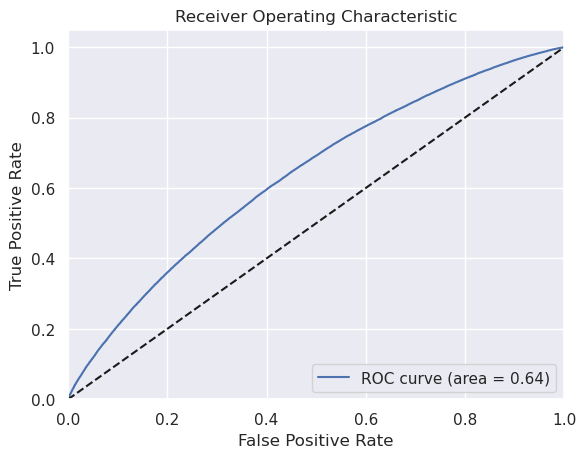


Accuracy: 0.7931
F1 Score: 0.0981
Precision: 0.5769
Recall: 0.0536 



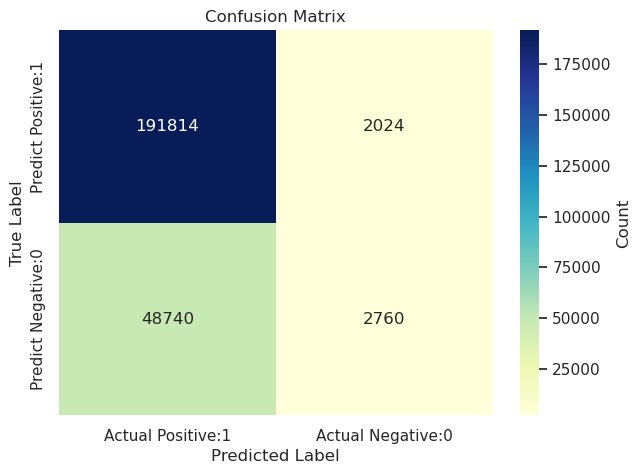

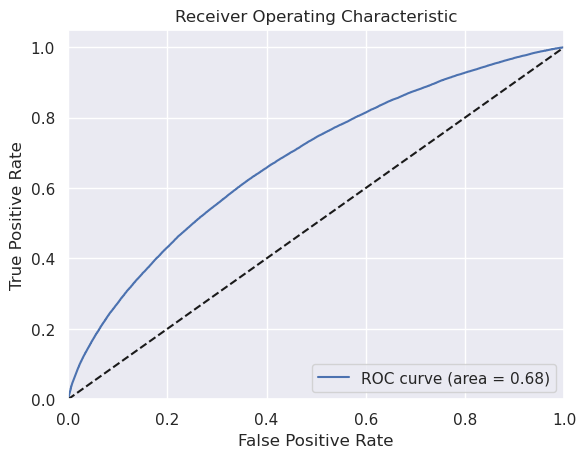

In [49]:
import json
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

s3 = boto3.client('s3')


#Combined1
# Fetching the data from S3
obj = s3.get_object(Bucket=bucket, Key="{}/batch_ll_output1/{}".format(prefix, 'batch-in1.csv.out'))
best_target_predicted1 = pd.read_csv(io.BytesIO(obj['Body'].read()), header=None, names=['predicted_probability'])

def parse_score(text):
    # Use regular expression to find the score in the string
    match = re.search(r"score:(\d+\.\d+)", text)
    if match:
        return float(match.group(1))
    return None

# Apply the function to extract scores
best_target_predicted1['score'] = best_target_predicted1['predicted_probability'].apply(parse_score)

test_labels1 = test1.iloc[:, 0]
best_target_predicted_binary1 = best_target_predicted1['score'].apply(binary_convert)

# Calculate the various performance metrics
accuracy1 = accuracy_score(test_labels1, best_target_predicted_binary1)
f11 = f1_score(test_labels1, best_target_predicted_binary1)
precision1 = precision_score(test_labels1, best_target_predicted_binary1)
recall1 = recall_score(test_labels1, best_target_predicted_binary1)

# Print the metrics
print("\nAccuracy: {:.4f}".format(accuracy1))
print("F1 Score: {:.4f}".format(f11))
print("Precision: {:.4f}".format(precision1))
print("Recall: {:.4f}".format(recall1), "\n")

# Function to plot the confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(data=cm, 
                         columns=['Actual Positive:1', 'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])
    
    # Plotting using seaborn
    plt.figure(figsize=(7,5))  # Set the figure size for better readability
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot ROC curve
def plot_roc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Apply a threshold to convert probabilities to binary predictions
def binary_convert(x, threshold=0.5):
    return 1 if x > threshold else 0

# Plotting the confusion matrix and ROC curve
plot_confusion_matrix(test_labels1, best_target_predicted_binary1)
plot_roc(test_labels1, best_target_predicted1['score'])



# combined2
# Fetching the data from S3
obj = s3.get_object(Bucket=bucket, Key="{}/batch_ll_output2/{}".format(prefix, 'batch-in2.csv.out'))
best_target_predicted2 = pd.read_csv(io.BytesIO(obj['Body'].read()), header=None, names=['predicted_probability'])

def parse_score(text):
    # Use regular expression to find the score in the string
    match = re.search(r"score:(\d+\.\d+)", text)
    if match:
        return float(match.group(1))
    return None

# Apply the function to extract scores
best_target_predicted2['score'] = best_target_predicted2['predicted_probability'].apply(parse_score)

test_labels2 = test2.iloc[:, 0]
best_target_predicted_binary2 = best_target_predicted2['score'].apply(binary_convert)

# Calculate the various performance metrics
accuracy2 = accuracy_score(test_labels2, best_target_predicted_binary2)
f12 = f1_score(test_labels2, best_target_predicted_binary2)
precision2 = precision_score(test_labels2, best_target_predicted_binary2)
recall2 = recall_score(test_labels2, best_target_predicted_binary2)

# Print the metrics
print("\nAccuracy: {:.4f}".format(accuracy2))
print("F1 Score: {:.4f}".format(f12))
print("Precision: {:.4f}".format(precision2))
print("Recall: {:.4f}".format(recall2), "\n")

# Plotting the confusion matrix and ROC curve
plot_confusion_matrix(test_labels2, best_target_predicted_binary2)
plot_roc(test_labels2, best_target_predicted2['score'])

# Step 3: Build and evaluate ensembe models

Write code to perform the following steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

### 1. Split data into training, validation and testing sets (70% - 15% - 15%).

In [50]:
#Split data for combined1
train1, test_and_validate1 = train_test_split(combined1, test_size=0.3, random_state=42, stratify=combined1['target'])
# split the *test_and_validate* dataset into two equal parts (15% each)
test1, validate1 = train_test_split(test_and_validate1, test_size=0.5, random_state=42, stratify=test_and_validate1['target'])

#Split data for combined2
train2, test_and_validate2 = train_test_split(combined2, test_size=0.3, random_state=42, stratify=combined2['target'])
# split the *test_and_validate* dataset into two equal parts (15% each)
test2, validate2 = train_test_split(test_and_validate2, test_size=0.5, random_state=42, stratify=test_and_validate2['target'])

# check the shape of the splited datasets of combined1
print(train1.shape)
print(test1.shape)
print(validate1.shape)

# check the shape of the splited datasets of combined2
print(train2.shape)
print(test2.shape)
print(validate2.shape)

# Define the filenames
train1_xgb_file='combine1_xgb_train.csv'
test1_xgb_file='combine1_xgb_test.csv'
validate1_xgb_file='combine1_xgb_validate.csv'

# Define the filenames
train2_xgb_file='combine2_xgb_train.csv'
test2_xgb_file='combine2_xgb_test.csv'
validate2_xgb_file='combine2_xgb_validate.csv'

# Define the function to upload the files to S3
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    # The io.StringIO() creates an in-memory text stream, which allows you to write CSV data to a file-like object instead of a physical disk.
    csv_buffer = io.StringIO()
    # Convert the DataFrame to CSV format and directly write it into the already created csv_buffer
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())
    
# Call the function to upload the files to S3 for combined1
upload_s3_csv(train1_xgb_file, 'train_xgb', train1)
upload_s3_csv(test1_xgb_file, 'test_xgb', test1)
upload_s3_csv(validate1_xgb_file, 'validate_xgb', validate1)

# Call the function to upload the files to S3 for combined2
upload_s3_csv(train2_xgb_file, 'train_xgb', train2)
upload_s3_csv(test2_xgb_file, 'test_xgb', test2)
upload_s3_csv(validate2_xgb_file, 'validate_xgb', validate2)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


(1144913, 75)
(245338, 75)
(245339, 75)
(1144913, 88)
(245338, 88)
(245339, 88)


In [51]:
#pip install -U sagemaker

### 2. Use xgboost estimator to build a classifcation model

In [54]:
# Retrieve the AWS region to find the right container image
container = retrieve('xgboost', boto3.Session().region_name, version = '1.7-1')

# Set up S3 output location
s3_output1_location = f"s3://{bucket}/{prefix}/output/xgboost-model_1/"
s3_output2_location = f"s3://{bucket}/{prefix}/output/xgboost-model_2/"

# Parameters
hyperparameters = {
    "eval_metric": "error@.40",
    "objective": "binary:logistic",
    "num_round": 42
}

# Create the Estimators for each dataset
xgb_estimator1 = sagemaker.estimator.Estimator(
    role=get_execution_role(),
    hyperparameters=hyperparameters,
    image_uri=container,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=s3_output1_location,
    sagemaker_session=sagemaker.Session()
)

xgb_estimator2 = sagemaker.estimator.Estimator(
    role=get_execution_role(),
    hyperparameters=hyperparameters,
    image_uri=container,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=s3_output2_location,
    sagemaker_session=sagemaker.Session()
)

# Setup data channels
train_xgb_input1 = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train_xgb/combine1_xgb_train.csv", 
    content_type="csv")
validation_xgb_input1 = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validate_xgb/combine1_xgb_validate.csv", 
    content_type="csv")

train_xgb_input2 = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train_xgb/combine2_xgb_train.csv", 
    content_type="csv")
validation_xgb_input2 = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validate_xgb/combine2_xgb_validate.csv", 
    content_type="csv")

# Fit the model
xgb_estimator1.fit({'train': train_xgb_input1, 'validation': validation_xgb_input1})
xgb_estimator2.fit({'train': train_xgb_input2, 'validation': validation_xgb_input2})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-31-05-34-21-422


2024-10-31 05:34:21 Starting - Starting the training job......
2024-10-31 05:35:04 Starting - Preparing the instances for training......
2024-10-31 05:36:09 Downloading - Downloading input data...
2024-10-31 05:36:55 Downloading - Downloading the training image......
2024-10-31 05:37:50 Training - Training image download completed. Training in progress...[2024-10-31 05:38:06.809 ip-10-2-128-42.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-31 05:38:06.845 ip-10-2-128-42.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-31:05:38:07:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-31:05:38:07:INFO] Failed to parse hyperparameter eval_metric value error@.40 to Json.
Returning the value itself
[2024-10-31:05:38:07:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-10-31:05:38:07:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-3

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-31-05-40-10-404


Training seconds: 210
Billable seconds: 210
2024-10-31 05:40:13 Starting - Starting the training job...
2024-10-31 05:40:29 Starting - Preparing the instances for training...
2024-10-31 05:40:52 Downloading - Downloading input data......
2024-10-31 05:41:48 Downloading - Downloading the training image...
2024-10-31 05:42:29 Training - Training image download completed. Training in progress..[2024-10-31 05:42:39.873 ip-10-2-104-123.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-10-31 05:42:39.904 ip-10-2-104-123.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-10-31:05:42:40:INFO] Imported framework sagemaker_xgboost_container.training
[2024-10-31:05:42:40:INFO] Failed to parse hyperparameter eval_metric value error@.40 to Json.
Returning the value itself
[2024-10-31:05:42:40:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2024-10-31:05:42:40:INFO] No GPUs detected (

### 3. Host the model on another instance

In [55]:
# Deploy the trained models
xgb_predictor1 = xgb_estimator1.deploy(initial_instance_count=1, 
                                        instance_type='ml.m4.xlarge', 
                                        serializer=CSVSerializer())
xgb_predictor2 = xgb_estimator2.deploy(initial_instance_count=1, 
                                        instance_type='ml.m4.xlarge', 
                                        serializer=CSVSerializer())

# use the delete_endpoint function to delete the endpoint
xgb_predictor1.delete_endpoint(delete_endpoint_config=True)

# use the delete_endpoint function to delete the endpoint
xgb_predictor2.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-31-05-46-08-578
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-10-31-05-46-08-578
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-10-31-05-46-08-578


-------!

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-31-05-50-10-557
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-10-31-05-50-10-557
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-10-31-05-50-10-557


---------!

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-10-31-05-46-08-578
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-10-31-05-46-08-578
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-10-31-05-50-10-557
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-10-31-05-50-10-557


### 4. Perform batch transform to evaluate the model on testing data

In [56]:
# Select the columns excluding the target column for the batch transform input
batch_xgb_X1 = test1.iloc[:,1:]; 
batch_xgb_X2 = test2.iloc[:,1:]; 

# Replace 'TRUE'/'FALSE' strings with 1 and 0
batch_xgb_X1 = batch_xgb_X1.replace({'TRUE': 1, 'FALSE': 0})
batch_xgb_X2 = batch_xgb_X2.replace({'TRUE': 1, 'FALSE': 0})

# Convert all boolean columns to integers (True to 1, False to 0)
batch_xgb_X1 = batch_xgb_X1.applymap(lambda x: int(x) if isinstance(x, bool) else x)
batch_xgb_X2 = batch_xgb_X2.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Files for batch transform input
batch_xgb_X1_file='batch-in1.csv'
batch_xgb_X2_file='batch-in2.csv'

# upload_s3_csv(filename, folder, dataframe)
upload_s3_csv(batch_xgb_X1_file, 'batch_xgb_in', batch_xgb_X1)
upload_s3_csv(batch_xgb_X2_file, 'batch_xgb_in', batch_xgb_X2)

# Define the output paths for the batch transform results
batch_xgb_output1 = f"s3://{bucket}/{prefix}/batch_xgb_output1/"
batch_xgb_output2 = f"s3://{bucket}/{prefix}/batch_xgb_output2/"

# Define input paths for the batch transform data
batch_xgb_input1 = f"s3://{bucket}/{prefix}/batch_xgb_in/{batch_xgb_X1_file}"
batch_xgb_input2 = f"s3://{bucket}/{prefix}/batch_xgb_in/{batch_xgb_X2_file}"

# Create transformer objects for both models
xgb_transformer1 = xgb_estimator1.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=batch_xgb_output1,
    strategy='MultiRecord',
    assemble_with='Line'
)

xgb_transformer2 = xgb_estimator2.transformer(
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=batch_xgb_output2,
    strategy='MultiRecord',
    assemble_with='Line'
)

# Perform batch transformations
xgb_transformer1.transform(
    data=batch_xgb_input1,
    content_type='text/csv',
    split_type='Line'
)

xgb_transformer2.transform(
    data=batch_xgb_input2,
    content_type='text/csv',
    split_type='Line'
)

# Wait for transformation jobs to complete
xgb_transformer1.wait()
xgb_transformer2.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-31-05-55-39-526
INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-31-05-55-40-156
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-31-05-55-41-949


..........................................
[2024-10-31:06:02:37:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-31:06:02:37:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-31:06:02:37:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
[2024-10-31:06:02:37:INFO] No GPUs detected

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-10-31-06-03-06-810


.........................................[2024-10-31:06:09:54:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-31:06:09:54:INFO] No GPUs detected (normal if no gpus installed)
[2024-10-31:06:09:54:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-10-31 06:09:54 +0000] [18] [INFO] Sta

### 5. Report the performance metrics that you see better test the model performance 


Accuracy: 0.7901
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000 



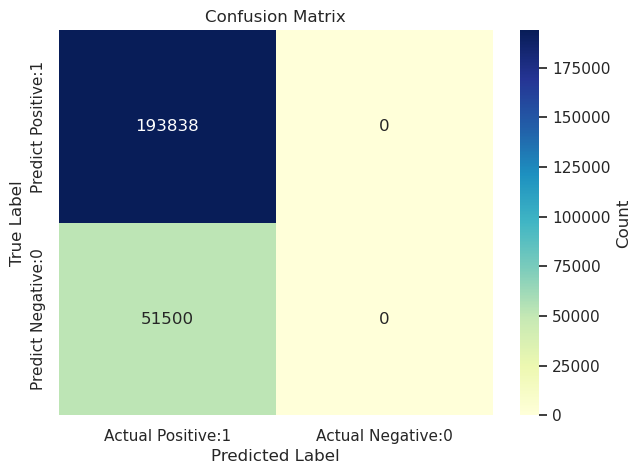

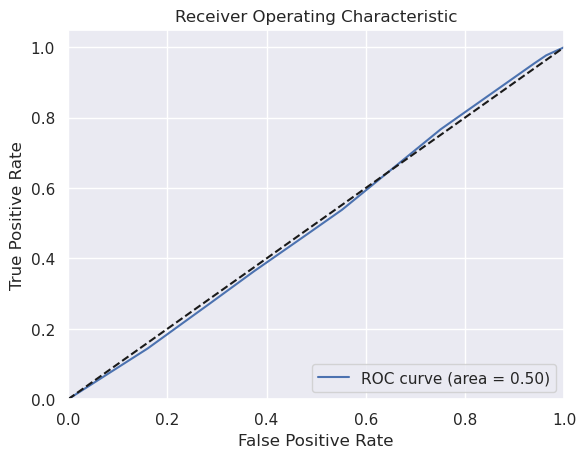


Accuracy: 0.7911
F1 Score: 0.0142
Precision: 0.7445
Recall: 0.0072 



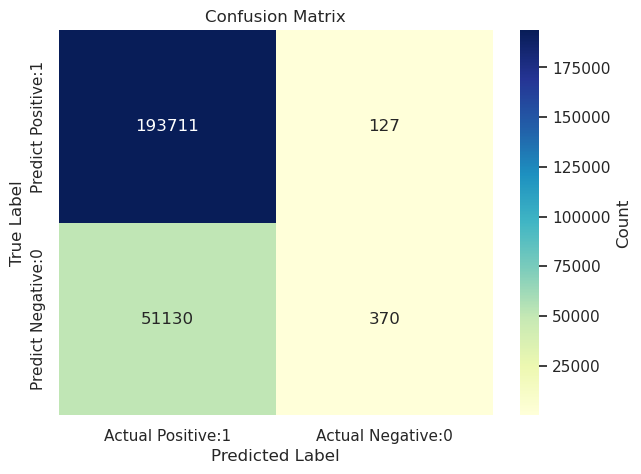

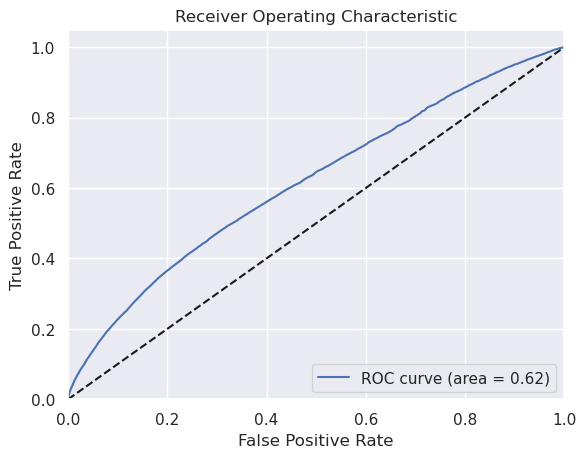

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

s3 = boto3.client('s3')

# Fetching the data from S3
obj = s3.get_object(Bucket=bucket, Key="{}/batch_xgb_output1/{}".format(prefix, 'batch-in1.csv.out'))
best_target_predicted1 = pd.read_csv(io.BytesIO(obj['Body'].read()), header=None, names=['predicted_probability'])

test_labels1 = test1.iloc[:, 0]
best_target_predicted_binary1 = best_target_predicted1['predicted_probability'].apply(binary_convert)
# Calculate the various performance metrics
accuracy1 = accuracy_score(test_labels1, best_target_predicted_binary1)
f11 = f1_score(test_labels1, best_target_predicted_binary1)
precision1 = precision_score(test_labels1, best_target_predicted_binary1)
recall1 = recall_score(test_labels1, best_target_predicted_binary1)

# Print the metrics
print("\nAccuracy: {:.4f}".format(accuracy1))
print("F1 Score: {:.4f}".format(f11))
print("Precision: {:.4f}".format(precision1))
print("Recall: {:.4f}".format(recall1), "\n")

# Function to plot the confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(data=cm, 
                         columns=['Actual Positive:1', 'Actual Negative:0'], 
                         index=['Predict Positive:1', 'Predict Negative:0'])
    
    # Plotting using seaborn
    plt.figure(figsize=(7,5))  # Set the figure size for better readability
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Function to plot ROC curve
def plot_roc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Apply a threshold to convert probabilities to binary predictions
def binary_convert(x, threshold=0.5):
    return 1 if x > threshold else 0

# Plotting the confusion matrix and ROC curve
plot_confusion_matrix(test_labels1, best_target_predicted_binary1)
plot_roc(test_labels1, best_target_predicted1['predicted_probability'])

# Fetching the data from S3
obj = s3.get_object(Bucket=bucket, Key="{}/batch_xgb_output2/{}".format(prefix, 'batch-in2.csv.out'))
best_target_predicted2 = pd.read_csv(io.BytesIO(obj['Body'].read()), header=None, names=['predicted_probability'])

test_labels2 = test2.iloc[:, 0]
best_target_predicted_binary2 = best_target_predicted2['predicted_probability'].apply(binary_convert)

# Calculate the various performance metrics
accuracy2 = accuracy_score(test_labels2, best_target_predicted_binary2)
f12 = f1_score(test_labels2, best_target_predicted_binary2)
precision2 = precision_score(test_labels2, best_target_predicted_binary2)
recall2 = recall_score(test_labels2, best_target_predicted_binary2)

# Print the metrics
print("\nAccuracy: {:.4f}".format(accuracy2))
print("F1 Score: {:.4f}".format(f12))
print("Precision: {:.4f}".format(precision2))
print("Recall: {:.4f}".format(recall2), "\n")

# Plotting the confusion matrix and ROC curve
plot_confusion_matrix(test_labels2, best_target_predicted_binary2)
plot_roc(test_labels2, best_target_predicted2['predicted_probability'])


### 6. write down your observation on the difference between the performance of using the simple and ensemble models.

By comparing the Linear Learner with XGBoost, it is observable that each of these has different strengths in the following: 

Accuracy: It is high for both models, but it is misleading information when the datasets are imbalanced.

Precision and Recall:

* Linear Learner: Though it has high precision, it has low recall, meaning it seldom predicts positive cases correctly.

* XGBoost: It strikes a better balance, improving both precision and recall.

F1 Score and AUC:

This is supported by a low F1 Score and AUC, 0.50, which indicates that the linear model has a hard time trying to separate classes.
XGBoost has shown a higher F1 Score and AUC, which means that in this classifier, much better performance can be seen in distinguishing classes.